# Healthcare: Diabetes Prediction

NIDDK (National Institute of Diabetes and Digestive and Kidney Diseases) research creates knowledge about and treatments for the most chronic, costly, and consequential diseases.

The dataset used in this project is originally from NIDDK. The objective is to predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset.

The objective is to build a model to accurately predict whether the patients in the dataset have diabetes or not.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import metrics
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv("health care diabetes.csv")

In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


The dataset consists of several medical predictor variables and one target variable, Outcome. The variables are as follows:

- **Pregnancies:** Number of times pregnant
- **Glucose:** Plasma glucose concentration a 2 hours in an oral glucose tolerance test
- **BloodPressure:** Diastolic blood pressure (mm Hg)
- **SkinThickness:** Triceps skin fold thickness (mm)
- **Insulin:** 2-Hour serum insulin (mu U/ml)
- **BMI:** Body mass index (weight in kg/(height in m)^2)
- **DiabetesPedigreeFunction:** Diabetes pedigree function
- **Age:** Age (years)
- **Outcome:** Class variable (0 or 1) 268 of 768 are 1, the others are 0


### Descriptive Analysis

We run a few functions to examine the structure of the dataset.

In [4]:
df.shape #dataset dimensions

(768, 9)

In [5]:
df.isnull().any() #check for null values

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

In [6]:
df.duplicated().any() #check for duplicate values

False

In [7]:
df.info() #dataset information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [9]:
df.skew(axis = 0, skipna = True)

Pregnancies                 0.901674
Glucose                     0.173754
BloodPressure              -1.843608
SkinThickness               0.109372
Insulin                     2.272251
BMI                        -0.428982
DiabetesPedigreeFunction    1.919911
Age                         1.129597
Outcome                     0.635017
dtype: float64

In [10]:
df[df == 0].count() #checking for number of zero values per column

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

Examining the dataset, several columns have zero values where they would not make sense. These columns are Glucose, BloodPressure, SkinThickness, Insulin, and BMI. These are likely missing values, and we need to take a decision on how to treat them.

### Addressing missing values

In [11]:
df_clean = df
#df_clean.drop('Outcome', inplace=True, axis=1) #Dropping target column to reduce bias during imputation

#Setting the 0 values to NA
df_clean.loc[df_clean["Glucose"] == 0.0, "Glucose"] = np.NAN
df_clean.loc[df_clean["BloodPressure"] == 0.0, "BloodPressure"] = np.NAN
df_clean.loc[df_clean["SkinThickness"] == 0.0, "SkinThickness"] = np.NAN
df_clean.loc[df_clean["Insulin"] == 0.0, "Insulin"] = np.NAN
df_clean.loc[df_clean["BMI"] == 0.0, "BMI"] = np.NAN

df_clean.isnull().sum()[1:6]

Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

In [12]:
df_clean

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63,0
764,2,122.0,70.0,27.0,NaN,36.8,0.340,27,0
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30,0
766,1,126.0,60.0,NaN,NaN,30.1,0.349,47,1


<AxesSubplot:xlabel='SkinThickness', ylabel='Count'>

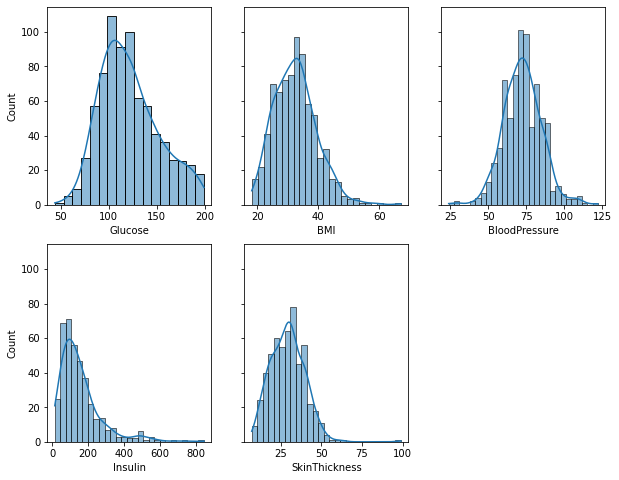

In [13]:
#Plotting the distributions of the columns excluding missing values
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,8), sharey= True)
fig.delaxes(ax[1][2])
sns.histplot(df_clean['Glucose'], kde = True, ax = ax[0][0])
sns.histplot(df_clean['BMI'], kde = True, ax = ax[0][1])
sns.histplot(df_clean['BloodPressure'], kde = True, ax = ax[0][2])
sns.histplot(df_clean['Insulin'], kde = True, ax = ax[1][0])
sns.histplot(df_clean['SkinThickness'], kde = True, ax = ax[1][1])

In [14]:
df_clean.skew(axis = 0, skipna = True)

Pregnancies                 0.901674
Glucose                     0.530989
BloodPressure               0.134153
SkinThickness               0.690619
Insulin                     2.166464
BMI                         0.593970
DiabetesPedigreeFunction    1.919911
Age                         1.129597
Outcome                     0.635017
dtype: float64

BMI, Glucose, and BloodPressure have relatively few missing values. None of them appear overly skewed and the distributions appear normal, so simple mean imputation could be possible. However, Insulin and SkinThickness have many null values, and simple imputation would probably create bias in the data. Thus, using a KNN imputer would be a better approach to address the missing values.

In [15]:
imputer = KNNImputer(n_neighbors=2)
df_clean = pd.DataFrame(imputer.fit_transform(df_clean), columns=df_clean.columns)
#df_clean[['Pregnancies', 'Age', 'Outcome']] = df_clean[['Pregnancies', 'Age', 'Outcome']].astype(int)
df_clean

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,113.0,33.6,0.627,50.0,1.0
1,1.0,85.0,66.0,29.0,88.5,26.6,0.351,31.0,0.0
2,8.0,183.0,64.0,24.0,227.5,23.3,0.672,32.0,1.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0.0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1.0
...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.0,180.0,32.9,0.171,63.0,0.0
764,2.0,122.0,70.0,27.0,202.5,36.8,0.340,27.0,0.0
765,5.0,121.0,72.0,23.0,112.0,26.2,0.245,30.0,0.0
766,1.0,126.0,60.0,33.5,123.5,30.1,0.349,47.0,1.0


<AxesSubplot:xlabel='SkinThickness', ylabel='Count'>

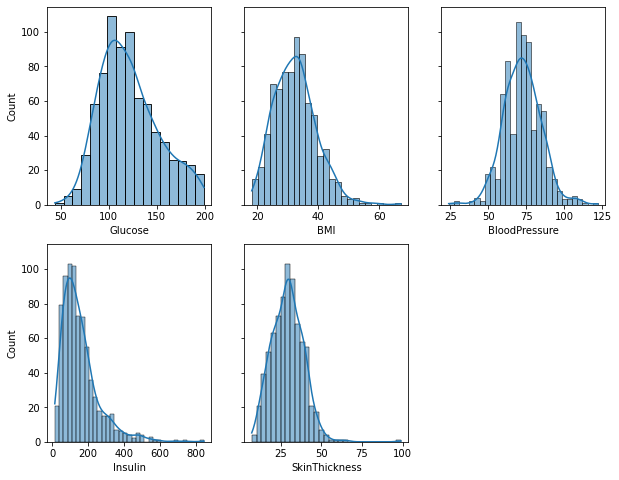

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,8), sharey= True)
fig.delaxes(ax[1][2])
sns.histplot(df_clean['Glucose'], kde = True, ax = ax[0][0])
sns.histplot(df_clean['BMI'], kde = True, ax = ax[0][1])
sns.histplot(df_clean['BloodPressure'], kde = True, ax = ax[0][2])
sns.histplot(df_clean['Insulin'], kde = True, ax = ax[1][0])
sns.histplot(df_clean['SkinThickness'], kde = True, ax = ax[1][1])

In [17]:
df_clean.skew(axis = 0, skipna = True)

Pregnancies                 0.901674
Glucose                     0.528124
BloodPressure               0.144293
SkinThickness               0.641226
Insulin                     1.952954
BMI                         0.603823
DiabetesPedigreeFunction    1.919911
Age                         1.129597
Outcome                     0.635017
dtype: float64

In [18]:
df_clean.isnull().sum()[1:6]

Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64

After imputation, the distributions of the data are largely unchanged.

### Balance of data

We check the output column to see if the dataset is balanced.

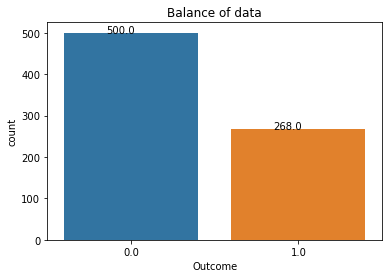

In [19]:
plt.title('Balance of data')
ax = sns.countplot(x = 'Outcome', data = df_clean)

for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))


In [20]:
df_clean['Outcome'].value_counts()

0.0    500
1.0    268
Name: Outcome, dtype: int64

The dataset is clearly imbalanced. To address this, we need to generate samples for the positive class. We can use SMOTE for this purpose.

In [21]:
X = df_clean.drop('Outcome', axis=1)
Y = df_clean['Outcome']
X.shape, Y.shape

((768, 8), (768,))

In [22]:
X_resampled, Y_resampled = SMOTE(random_state=42).fit_resample(X, Y)
X_resampled.shape, Y_resampled.shape

((1000, 8), (1000,))

In [23]:
Y_resampled.value_counts()

0.0    500
1.0    500
Name: Outcome, dtype: int64

The dataset is now balanced

### Variable Relationships

We examine the relationships between variable pairs by using scatterplots.

In [24]:
df_clean = pd.concat([X_resampled, Y_resampled], axis=1)
df_clean

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.000000,148.000000,72.000000,35.000000,113.000000,33.600000,0.627000,50.000000,1.0
1,1.000000,85.000000,66.000000,29.000000,88.500000,26.600000,0.351000,31.000000,0.0
2,8.000000,183.000000,64.000000,24.000000,227.500000,23.300000,0.672000,32.000000,1.0
3,1.000000,89.000000,66.000000,23.000000,94.000000,28.100000,0.167000,21.000000,0.0
4,0.000000,137.000000,40.000000,35.000000,168.000000,43.100000,2.288000,33.000000,1.0
...,...,...,...,...,...,...,...,...,...
995,4.590236,165.626850,64.795118,34.018307,225.795118,32.870008,0.366734,32.385354,1.0
996,3.553703,118.090734,67.355563,27.231485,151.607406,31.821481,0.213057,30.537031,1.0
997,4.276367,171.745442,86.000000,27.212728,155.787272,33.512728,1.161445,49.872721,1.0
998,6.730973,103.107611,66.753276,32.699471,197.623362,38.809451,0.363747,30.892389,1.0


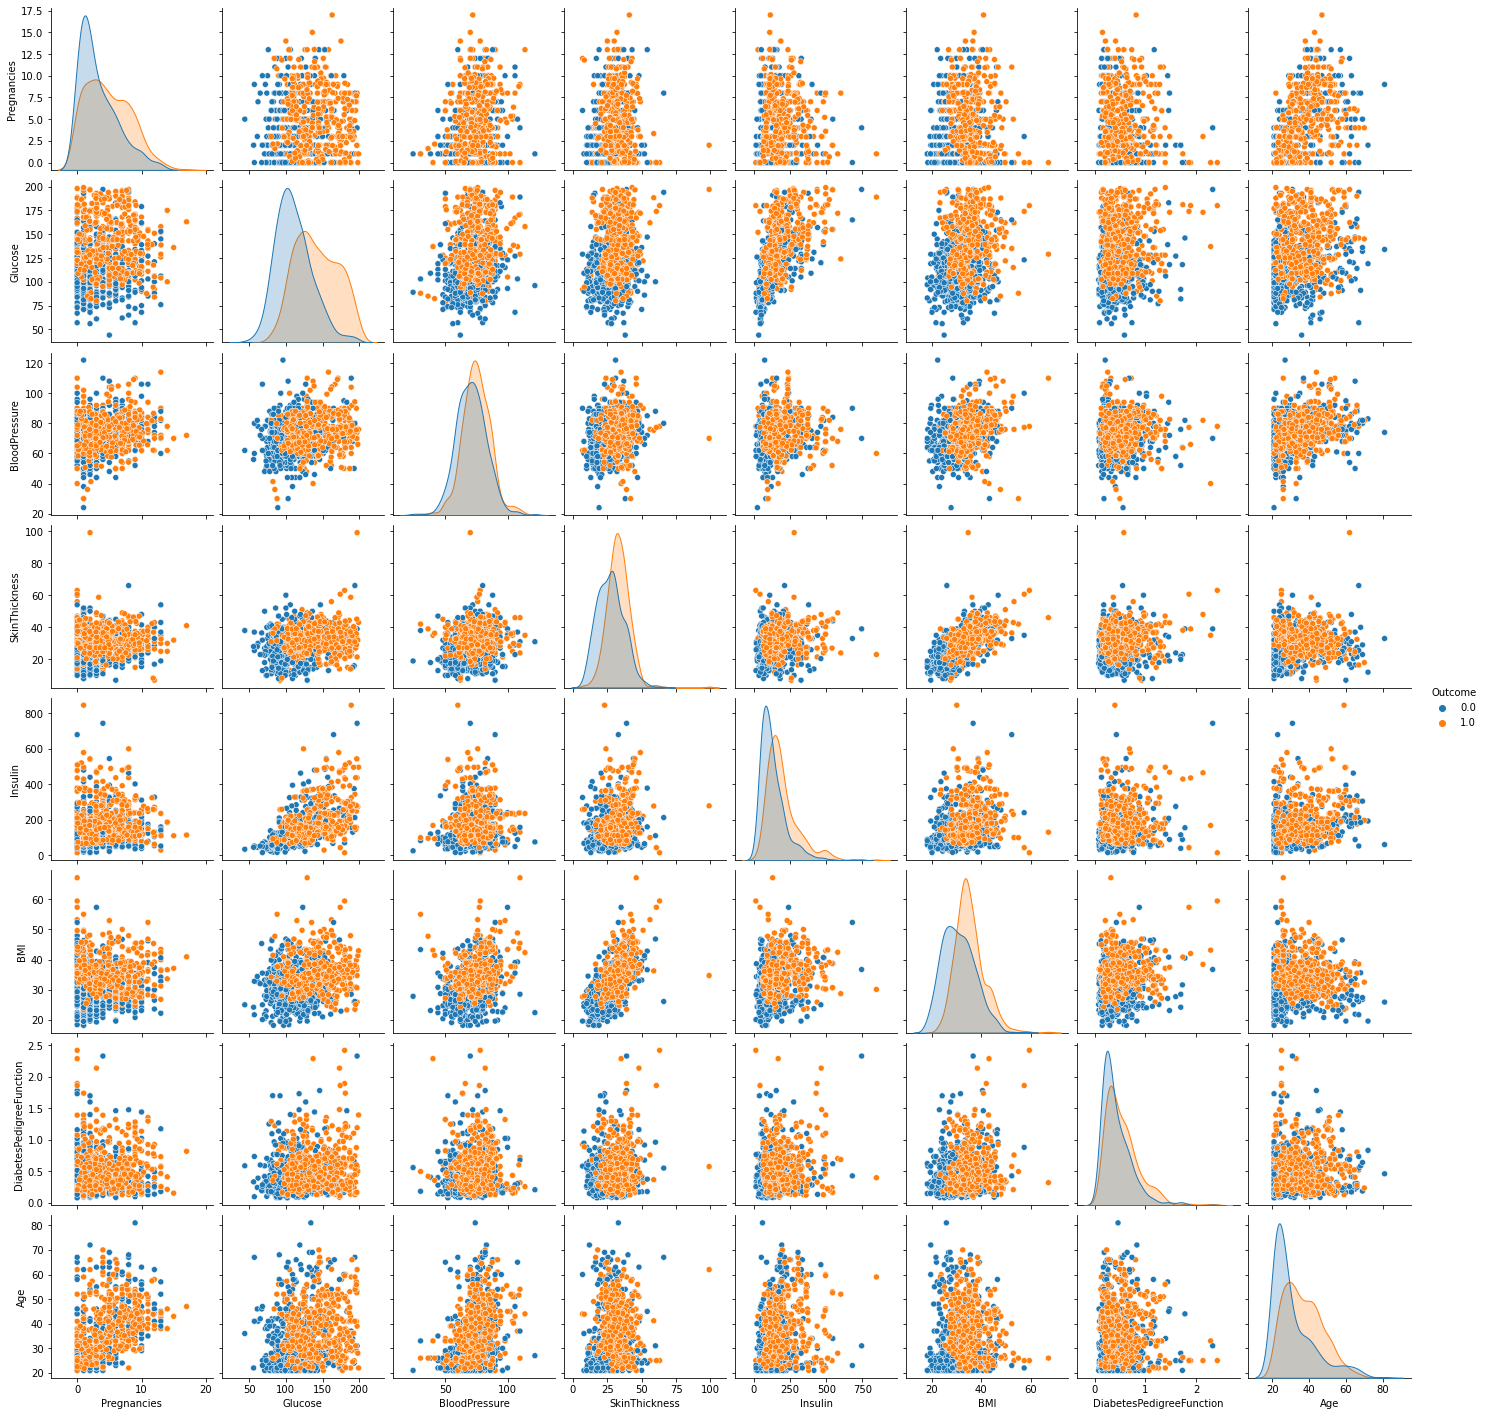

In [25]:
sns.pairplot(df_clean,hue= 'Outcome')

We can see indications of relationships between certain variables. Some examples could be SkinThickness and BMI, and Insulin and Glucose.

To examine these correlations further, we can generate a correlation matrix and use a heatmap.

<AxesSubplot:>

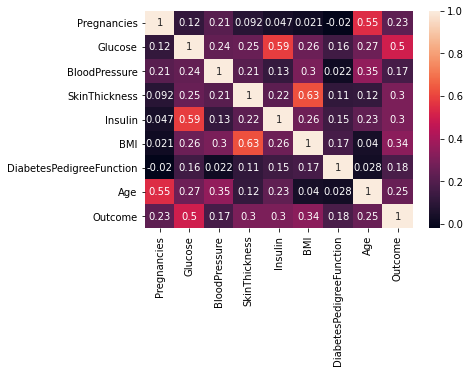

In [26]:
corr = df_clean.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)

The observations from this heatmap are consistent with our inferences from the scatterplots above. Outcome has some degree of correlation with all variables, with the largest being observed for Glucose.

## Data Modelling

We now test several different machine learning models to see which would be most suitable for diabetes prediction. As our objective is to predict the occurence of diabetes in patients, we should aim to minimize false negatives. Thus, accuracy would not be the most indicative metric for our purposes here. A more appropriate metric to track would instead be recall.

In [27]:
# Training/test split. The same train/test sets will be used for all models

x_train, x_test, y_train, y_test = train_test_split(X_resampled, Y_resampled, test_size=0.20, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((800, 8), (200, 8), (800,), (200,))

In [28]:
#Using standardization rather than normalization because we have not performed any outlier removal procedures
sc = StandardScaler()
X_train = sc.fit_transform(x_train) #Capital X denotes the standardized data while lowercase X denotes the raw data
X_test = sc.transform(x_test)

In [29]:
model_results = {}

### Logistic Regression

In [30]:
lr = LogisticRegression(max_iter=100, random_state=42)
lr.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [31]:
y_pred = lr.predict(X_test)

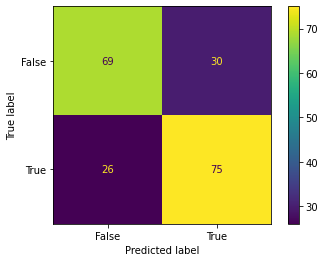

In [32]:
lr_conf = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = lr_conf, display_labels = [False, True])
cm_display.plot()

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.73      0.70      0.71        99
         1.0       0.71      0.74      0.73       101

    accuracy                           0.72       200
   macro avg       0.72      0.72      0.72       200
weighted avg       0.72      0.72      0.72       200



Text(0, 0.5, 'True Positive Rate')

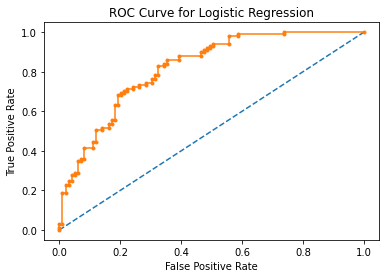

In [34]:
# preparing ROC curve

y_prob = lr.predict_proba(X_test)                
y_prob = y_prob[:, 1]                              # considering positive outcomes only

fpr, tpr, thresholds = roc_curve(y_test, y_prob)   # calculate roc
plt.plot([0, 1], [0, 1], linestyle='--')         
plt.plot(fpr, tpr, marker='.')                     # plot roc
plt.title("ROC Curve for Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

In [35]:
# Printing relevant metrics

lr_auc = roc_auc_score(y_test, y_pred)           
lr_f1 = f1_score(y_test, y_pred)
lr_rec = metrics.recall_score(y_test, y_pred)
print('f1 = %.2f, auc = %.2f, recall = %.2f' % (lr_f1, lr_auc, lr_rec)) 

f1 = 0.73, auc = 0.72, recall = 0.74


In [36]:
# Storing results for later comparison
model_results.update({"Logistic Regression": [lr_f1, lr_auc, lr_rec]})

The recall of this model for is 74%, which is okay but not ideal. Several patients with diabetes would be incorrectly predicted as healthy.

### Random Forest

In [37]:
rf = RandomForestClassifier(n_estimators = 100, random_state=42)
rf.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [38]:
y_pred = rf.predict(x_test)

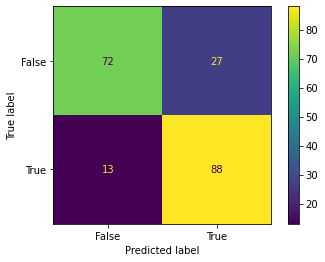

In [39]:
rf_conf = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = rf_conf, display_labels = [False, True])
cm_display.plot()

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.73      0.78        99
         1.0       0.77      0.87      0.81       101

    accuracy                           0.80       200
   macro avg       0.81      0.80      0.80       200
weighted avg       0.81      0.80      0.80       200



Text(0, 0.5, 'True Positive Rate')

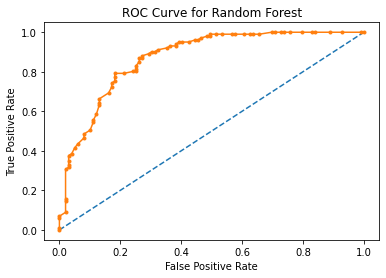

In [41]:
# preparing ROC curve for Random Forest

y_prob = rf.predict_proba(x_test)                
y_prob = y_prob[:, 1]                                                  

fpr, tpr, thresholds = roc_curve(y_test, y_prob)   
plt.plot([0, 1], [0, 1], linestyle='--')         
plt.plot(fpr, tpr, marker='.')                     
plt.title("ROC Curve for Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

In [42]:
rf_auc = roc_auc_score(y_test, y_pred)           
rf_f1 = f1_score(y_test, y_pred)
rf_rec = metrics.recall_score(y_test, y_pred)
print('f1 = %.2f, auc = %.2f, recall = %.2f' % (rf_f1, rf_auc, rf_rec))

f1 = 0.81, auc = 0.80, recall = 0.87


In [43]:
model_results.update({"Random Forest": [rf_f1, rf_auc, rf_rec]})

The recall of this model is 87%, which is much better than the previous model.

### Support Vector Machine

In [44]:
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train,y_train) #Using the standardized data

SVC(probability=True, random_state=42)

In [45]:
y_pred = svm.predict(X_test)

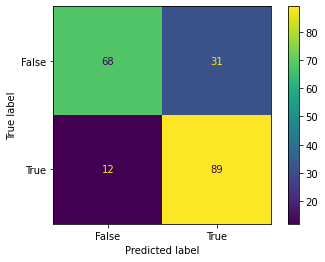

In [46]:
svm_conf = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = svm_conf, display_labels = [False, True])
cm_display.plot()

In [47]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.69      0.76        99
         1.0       0.74      0.88      0.81       101

    accuracy                           0.79       200
   macro avg       0.80      0.78      0.78       200
weighted avg       0.80      0.79      0.78       200



Text(0, 0.5, 'True Positive Rate')

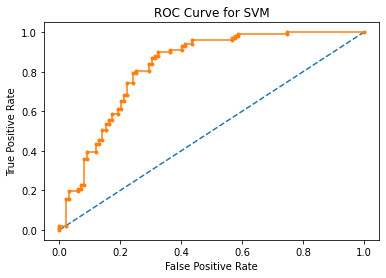

In [48]:
# preparing ROC curve for SVM

y_prob = svm.predict_proba(X_test)
y_prob = y_prob[:, 1]                                               

fpr, tpr, thresholds = roc_curve(y_test, y_prob)   
plt.plot([0, 1], [0, 1], linestyle='--')         
plt.plot(fpr, tpr, marker='.')                     
plt.title("ROC Curve for SVM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

In [49]:
svm_auc = roc_auc_score(y_test, y_pred)           
svm_f1 = f1_score(y_test, y_pred)
svm_rec = metrics.recall_score(y_test, y_pred)
print('f1 = %.2f, auc = %.2f, recall = %.2f' % (svm_f1, svm_auc, svm_rec))

f1 = 0.81, auc = 0.78, recall = 0.88


In [50]:
model_results.update({"Support Vector Machine": [svm_f1, svm_auc, svm_rec]})

The recall of this model is 88%.

### KNN

In [51]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [52]:
y_pred = knn.predict(X_test)

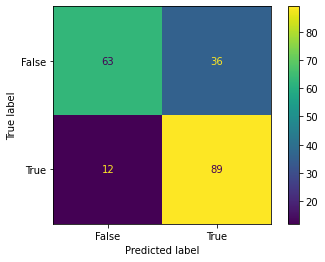

In [53]:
knn_conf = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = knn_conf, display_labels = [False, True])
cm_display.plot()

In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.64      0.72        99
         1.0       0.71      0.88      0.79       101

    accuracy                           0.76       200
   macro avg       0.78      0.76      0.76       200
weighted avg       0.78      0.76      0.76       200



Text(0, 0.5, 'True Positive Rate')

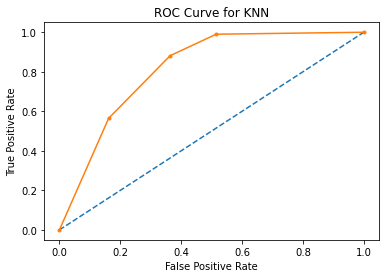

In [55]:
# preparing ROC curve for KNN

y_prob = knn.predict_proba(X_test)
y_prob = y_prob[:, 1]                            

fpr, tpr, thresholds = roc_curve(y_test, y_prob)   
plt.plot([0, 1], [0, 1], linestyle='--')         
plt.plot(fpr, tpr, marker='.')                     
plt.title("ROC Curve for KNN")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

In [56]:
knn_auc = roc_auc_score(y_test, y_pred)           
knn_f1 = f1_score(y_test, y_pred)
knn_rec = metrics.recall_score(y_test, y_pred)
print('f1 = %.2f, auc = %.2f, recall = %.2f' % (knn_f1, knn_auc, knn_rec))

f1 = 0.79, auc = 0.76, recall = 0.88


In [57]:
model_results.update({"KNN": [knn_f1, knn_auc, knn_rec]})

### Conclusion

In [58]:
model_results_df = pd.DataFrame(data = model_results, index=['F1 score', 'AUC', 'Recall']).T

In [59]:
model_results_df

,F1 score,AUC,Recall
Logistic Regression,0.728155,0.719772,0.742574
Random Forest,0.814815,0.799280,0.871287
Support Vector Machine,0.805430,0.784028,0.881188
KNN,0.787611,0.758776,0.881188


The two best models seem to be random forest and support vector machine. There are only slight differences between them, but the SVM appears to be marginally better at minimizing false negatives while random forest produces slightly better overall predictions. The appropriate model can be selected as per requirements.

### Data Visualization

The tableau visualization of the data can be found here: https://public.tableau.com/views/CapstoneProject2_16671233382650/Dashboard1?:language=en-GB&:display_count=n&:origin=viz_share_link